## Importation des librairies et transformation des données

In [9]:
import pandas as pd
import pickle as pk
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
#Chargement du dataframe
df_customer = pd.read_csv('./csv/shopping_behavior_updated.csv', sep=";")

#On regroupe notre dataframe en fonction des colonnes Age, Gender, Location, Subscription Status, Frequency of Purchases
df_customer_info_grouped = df_customer.groupby(['Age','Gender', 'Location', 'Subscription Status','Frequency of Purchases'])

def group_values (series):
    return list(series)
#On regroupe les produits achetés par les clients
aggregated_product = df_customer_info_grouped['Item Purchased'].apply(lambda x: ', '.join(x)).reset_index()


#On créer notre dataframe correspondant au regroupement des produits achetés par les clients
df_grouped_customer_purchase = pd.DataFrame(aggregated_product)

print("Aggregated product")
print(df_grouped_customer_purchase)

df_grouped_customer_purchase.to_csv('./csv/grouped_customer_purchase.csv', sep=';', index=False)

Aggregated product
      Age  Gender    Location Subscription Status Frequency of Purchases  \
0      18  Female      Alaska                  No                 Weekly   
1      18  Female    Illinois                  No            Fortnightly   
2      18  Female      Kansas                  No               Annually   
3      18  Female    Kentucky                  No            Fortnightly   
4      18  Female    Maryland                  No               Annually   
...   ...     ...         ...                 ...                    ...   
3744   70    Male       Texas                  No         Every 3 Months   
3745   70    Male       Texas                 Yes                Monthly   
3746   70    Male     Vermont                  No                Monthly   
3747   70    Male     Vermont                 Yes               Annually   
3748   70    Male  Washington                 Yes              Bi-Weekly   

      Item Purchased  
0             Shorts  
1              Shirt  

## Création de la table des produits

In [10]:
#On récupère l'ensemble des valeurs unique des produits
u_products = df_grouped_customer_purchase['Item Purchased'].str.split(', ', expand = True).stack().unique()

#On créer un dictionnaire qui représente la table d'achats des produits
data = {}

#On modifie la valeur stocké si le client a acheté ce produit
for i, row in df_grouped_customer_purchase.iterrows():
    items = row['Item Purchased'].split(', ')
    for item in items:
        if item not in data:
            data[item] = [0] * len(df_grouped_customer_purchase)
        data[item][i] += 1
df_product_table = pd.DataFrame(data)


print(df_product_table)
df_product_table.to_csv('./csv/product_table.csv', sep=';', index=False)


      Shorts  Shirt  Socks  Coat  Dress  Boots  Handbag  Sunglasses  Hat  \
0          1      0      0     0      0      0        0           0    0   
1          0      1      0     0      0      0        0           0    0   
2          0      0      1     0      0      0        0           0    0   
3          0      0      0     1      0      0        0           0    0   
4          0      0      0     0      1      0        0           0    0   
...      ...    ...    ...   ...    ...    ...      ...         ...  ...   
3744       0      0      0     0      0      0        0           0    0   
3745       0      0      0     0      0      0        0           0    0   
3746       0      0      0     0      0      0        0           0    0   
3747       0      0      0     0      0      0        0           0    0   
3748       0      0      0     0      0      0        0           0    0   

      Belt  ...  Sneakers  Sweater  Pants  T-shirt  Jewelry  Skirt  Blouse  \
0        

## Encodage des données

In [11]:
#Indexe des colonnes catégorielles (Gender,Location, Subscription Status, Frequency of Purchases)
cols_cat_info = [1,2,3,4]

#On créer une copie de notre dataframe source
df_grouped_customer = df_grouped_customer_purchase.copy()

#On supprime la colonne des achats
df_grouped_customer = df_grouped_customer.drop(columns=['Item Purchased'])
a_grouped_customer = df_grouped_customer.values
#Encodage des colonnes catégorielles
label_encoders_info = [LabelEncoder() for _ in range(len(cols_cat_info))]
for i, col_idx in enumerate(cols_cat_info):
    a_grouped_customer[:, col_idx] = label_encoders_info[i].fit_transform(a_grouped_customer[:, col_idx])
    
with open('./pickles/label_encoders_info.pkl', 'wb') as f:
    pk.dump(label_encoders_info, f)
#Print des données encodées
print(a_grouped_customer)


[[18 0 1 0 6]
 [18 0 12 0 3]
 [18 0 15 0 0]
 ...
 [70 1 44 0 4]
 [70 1 44 1 0]
 [70 1 46 1 1]]


## Initialisation du modèle

In [12]:
from sklearn.multioutput import RegressorChain
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

a_product_table = df_product_table.values
#Initialisation du modèle
chained_model = RegressorChain(RandomForestRegressor(n_estimators=100, random_state=1), random_state=1)
chained_model.fit(a_grouped_customer, a_product_table)

y_pred = chained_model.predict(a_grouped_customer)
print("MSE : ",mean_squared_error(a_product_table, y_pred))
print(y_pred[0])

MSE :  0.006184065084022406
[0.71 0.12 0.02 0.01 0.   0.06 0.02 0.01 0.   0.04 0.01 0.04 0.02 0.
 0.02 0.03 0.   0.   0.01 0.02 0.03 0.07 0.   0.01 0.04]


[0.352094   0.05653449 0.36322595 0.03909252 0.18905304]
Index(['Age', 'Gender', 'Location', 'Subscription Status',
       'Frequency of Purchases'],
      dtype='object')
Liste des variables selon leur importance dans l'ordre décroissant
Location
Age
Frequency of Purchases
Gender
Subscription Status


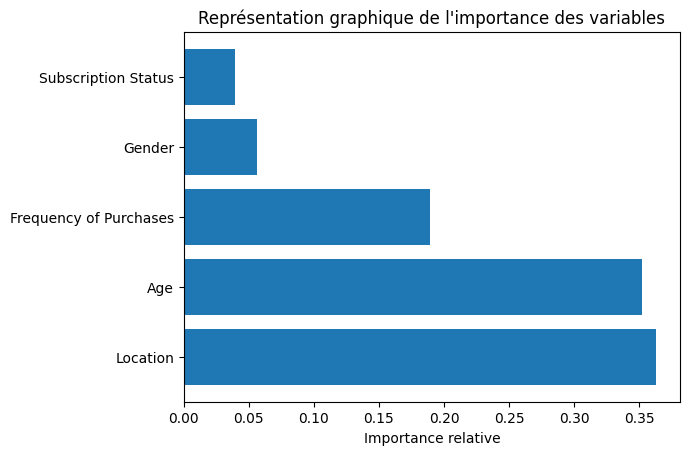

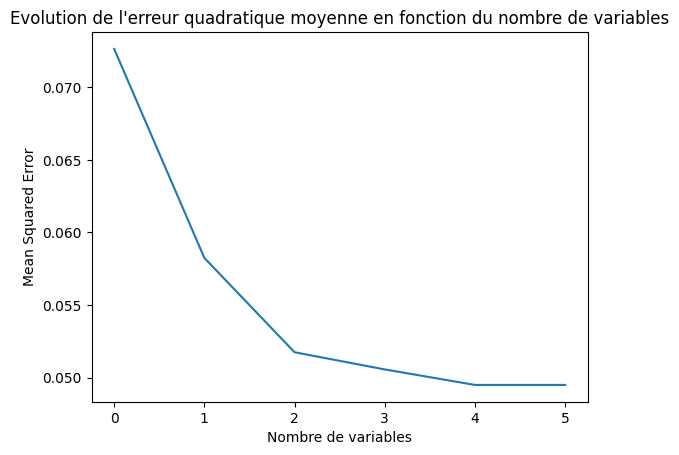

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

# Diviser les données en ensembles d'apprentissage et de test
x_train, x_test, y_train, y_test = train_test_split(a_grouped_customer, a_product_table, test_size=0.5, random_state=1)



# Entraîner un modèle RandomForestRegressor pour l'importance des caractéristiques
rf_regressor = RandomForestRegressor(n_estimators=100)
rf_regressor.fit(x_train, y_train)
importances = rf_regressor.feature_importances_


sorted_idx = np.argsort(importances)[::-1]
features = df_grouped_customer.columns

print(features)
# Afficher l'importance des variables
print("Liste des variables selon leur importance dans l'ordre décroissant")
for i in sorted_idx:
    print(features[i])

# Représentation graphique de l'importance des variables
padding = np.arange(x_train.size/x_train.shape[0]) + 0.5 
plt.barh(padding, importances[sorted_idx], align='center') 
plt.yticks(padding, features[sorted_idx]) 
plt.xlabel("Importance relative")
plt.title("Représentation graphique de l'importance des variables") 
plt.show()

# Entraîner un modèle MLPRegressor
mlp_regressor = chained_model = RegressorChain(RandomForestRegressor(n_estimators=100, random_state=1), random_state=1)
scores = np.zeros(x_train.shape[1] + 1)

# Evaluer l'accuracy en fonction du nombre de variables
for f in np.arange(0, x_train.shape[1] + 1):
    X1_f = x_train[:, sorted_idx[:f+1]]
    X2_f = x_test[:, sorted_idx[:f+1]]
    mlp_regressor.fit(X1_f, y_train)
    Y_pred = mlp_regressor.predict(X2_f)
    scores[f] = mean_squared_error(y_test, Y_pred)

# Afficher l'évolution de l'accuracy en fonction du nombre de variables
plt.plot(scores)
plt.xlabel("Nombre de variables")
plt.ylabel("Mean Squared Error")
plt.title("Evolution de l'erreur quadratique moyenne en fonction du nombre de variables")
plt.show()


In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, KFold
import numpy as np
import time

def run_regressor_chain_estimators(estimators, X, y):
    """
    Teste différents base estimators avec une RegressorChain et retourne les scores.

    Args:
    - estimators: Dictionnaire contenant les noms et les base estimators à tester.
    - X: Tableau NumPy des caractéristiques des clients.
    - y: Tableau NumPy des cibles (achats de produits).

    Returns:
    - best_estimator: Meilleur base estimator obtenu avec le score correspondant.
    """

    all_scores = []

    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    for clf_name, clf in estimators.items():
        start = time.time()

        # Créez le modèle RegressorChain avec le base_estimator actuel et spécifiez le nombre de folds
        chain = RegressorChain(base_estimator=clf, cv=2, random_state=1)

        # Effectuez la validation croisée
        cv_results = cross_validate(chain, X, y, scoring='neg_mean_squared_error', return_train_score=False, cv=kf, n_jobs=-1)

        end = time.time()

        # Stockez les résultats dans all_scores
        all_scores.append([clf, np.mean(cv_results['test_score']), np.mean(cv_results['fit_time'])])
        
        # Affichez les résultats pour le modèle actuel
        print(f"Base estimator: {clf_name}")
        print(f"Mean MSE : {np.mean(cv_results['test_score']):.3f}")
        print(f"Mean fit time: {np.mean(cv_results['fit_time']):.3f} seconds")
        print("\n")


    # Trouvez le meilleur base estimator en fonction du score moyen
    all_scores.sort(key=lambda x: x[1], reverse=True)
    best_estimator = all_scores[0][0]
    best_score = all_scores[0][1]
    best_fit_time = all_scores[0][2]

    print("Best base estimator is:", best_estimator)
    print("with a mean MSE of =", best_score)
    print("and a mean fit time of =", best_fit_time, "seconds")

    return best_estimator

In [15]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor

# Liste des base estimators à tester
base_estimators = {
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100,random_state=1, max_depth=5),
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso(random_state=1),
    'ElasticNet': ElasticNet(random_state=1),
    'SVR': SVR(),
    'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=5),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1),
    'XGBRegressor': XGBRegressor(n_estimators=100,random_state=1),
    'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=100,random_state=1),
}

# Utilisez la fonction run_regressor_chain_estimators avec la liste de base estimators
best_estimator = run_regressor_chain_estimators(base_estimators, a_grouped_customer, a_product_table)


Base estimator: RandomForestRegressor
Mean MSE : -0.045
Mean fit time: 75.315 seconds

Base estimator: LinearRegression
Mean MSE : -0.041
Mean fit time: 0.233 seconds


Base estimator: Ridge
Mean MSE : -0.040
Mean fit time: 0.159 seconds

Base estimator: Lasso
Mean MSE : -0.040
Mean fit time: 0.174 seconds


Base estimator: ElasticNet
Mean MSE : -0.040
Mean fit time: 0.165 seconds

Base estimator: SVR
Mean MSE : -0.043
Mean fit time: 6.316 seconds

Base estimator: KNeighborsRegressor
Mean MSE : -0.048
Mean fit time: 1.216 seconds

Base estimator: DecisionTreeRegressor
Mean MSE : -0.097
Mean fit time: 0.467 seconds

Base estimator: XGBRegressor
Mean MSE : -0.053
Mean fit time: 30.410 seconds

Base estimator: GradientBoostingRegressor
Mean MSE : -0.041
Mean fit time: 60.809 seconds


Best base estimator is: Lasso(random_state=1)
with a mean MSE of = -0.04010804619236314
and a mean fit time of = 0.17376406192779542 seconds


Lasso

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.multioutput import RegressorChain

# Créer un pipeline avec la RegressorChain et le modèle Lasso
pipeline = Pipeline([
    ('chain', RegressorChain(base_estimator=Lasso()))
])

# Définissez les hyperparamètres que vous souhaitez optimiser
param_grid = {
    'chain__base_estimator__alpha': [0.001, 0.01, 0.1, 1.0],  # Valeurs à tester pour le paramètre d'ajustement alpha
    'chain__base_estimator__max_iter': [100, 500, 1000]  # Nombre maximum d'itérations
}

# Initialisez l'objet GridSearchCV avec le pipeline et les hyperparamètres à optimiser
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='neg_mean_squared_error')

# Entraînez le modèle avec la recherche par grille
grid_search.fit(a_grouped_customer,a_product_table)

# Affichez les meilleurs hyperparamètres et la meilleure MSE
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleure MSE:", grid_search.best_score_)


Meilleurs hyperparamètres: {'chain__base_estimator__alpha': 1.0, 'chain__base_estimator__max_iter': 100}
Meilleure MSE: -0.04011206789742218


## Création de la pipeline finale mise en place d'un pickle

In [26]:
import pickle as pk
pipeline = Pipeline([
    ('chain', RegressorChain(base_estimator=Lasso(alpha=0.001, max_iter=100)))
])

x_train, x_test, y_train, y_test = train_test_split(a_grouped_customer, a_product_table, test_size=0.5, random_state=1)

pipeline.fit(a_grouped_customer,a_product_table)
prediction = pipeline.predict(x_test)
print("MSE : ",mean_squared_error(y_test, prediction))

print(pipeline.predict([[18, 0, 1, 0, 6]]))


MSE :  0.040212798399542574
[[0.04176069 0.06561338 0.02893877 0.05409358 0.04186006 0.03291212
  0.03334467 0.03917525 0.04366221 0.05452806 0.04430423 0.02971117
  0.03940041 0.03173757 0.03512472 0.03916437 0.05308747 0.05429604
  0.04064444 0.04213701 0.05057338 0.03904797 0.04738673 0.03490643
  0.02624691]]
